# Quasi-Newton
Example: $$\min -\sum_{1=1}^m\log(1-a_i^T x)-\sum_{i=1}^n\log\left(1-x_i^2\right)$$

In [22]:
import numpy as np
from newton import newton, plot_error_iter, solve_by_cvx


In [23]:
import torch

# Set device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# m: number of constraints
# n: number of variables
m = 500
n = 2000
A = torch.randn(m, n, device=device, dtype=torch.float64)
b = torch.ones(m, device=device, dtype=torch.float64)
# f_exact = solve_by_cvx(A.cpu(),b.cpu())
# Save A and b to file
# np.save('A.npy', A.cpu().numpy())
# np.save('b.npy', b.cpu().numpy())

f = lambda x: -torch.sum(torch.log(1 - A @ x)) - torch.sum(torch.log(1 - x**2))
grad_f = lambda x: A.T @ (1/(1 - A @ x)) + 2*x/(1 - x**2)
nabla_f = lambda x: A.T @ torch.diag(1/(1 - A @ x)**2) @ A + torch.diag(2/(1 - x**2)**2)

def dom_f(x, A=A, b=b):
    cons_1 = A @ x - b < 0
    cons_2 = torch.abs(x) - 1 < 0
    return torch.all(cons_1) and torch.all(cons_2)


# define optimization function
def quasi_newton_gpu(f, grad_f, x0, domf, MAXITERS=100, TOL=1e-8,alpha = 0.01, beta = 0.8, print_iter=False, N=1, diag_only=False, decrement_func=None):
    MAXITERS = MAXITERS
    TOL = TOL
    alpha = alpha
    beta = beta
    f, grad_f, domf = f, grad_f, domf
    
    x = x0.clone().to(device)
    n = len(x)
    
    if not decrement_func:
        decrement = lambda dx, B: dx @ B @ dx
    else:
        decrement = decrement_func
        
    decrement_value_list = []
    obj_list = [f(x)]
    x_list = [x]
    
    B = torch.eye(n).to(device, dtype=torch.float64)
    B_inv = torch.eye(n).to(device, dtype=torch.float64)
    grad = grad_f(x)

    for iters in range(1, MAXITERS):

        dx = -B_inv @ grad

        decrement_value = decrement(dx, B)
        decrement_value_list.append(decrement_value)
        if decrement_value/2 < TOL:
            break
        t = 1
        while not domf(x + t*dx):
            t *= beta
        while f(x + t*dx) > f(x) - alpha * t * decrement_value:
            t *= beta

        x += t*dx
        grad_new = grad_f(x)
        s = t * dx
        y = grad_new - grad
        
        if iters % N == 0 and iters != 1:
            # BFGS update rule.
            # Update for every N iterations.
            denom = y @ s
            B_new = B - torch.outer(B @ s, B @ s)/(s @ B @ s) + torch.outer(y, y)/denom
            B_inv_new = (torch.eye(n).to(device)-torch.outer(s,y)/denom).matmul(B_inv).matmul(torch.eye(n).to(device)-torch.outer(y,s)/denom) + torch.outer(s,s)/denom
            
            B_inv = B_inv_new
            B = B_new
            
        grad = grad_new

        x_list.append(x)
        obj_list.append(f(x))

    return x_list, obj_list


In [40]:
x0 = torch.zeros(n, device=device, dtype=torch.float64)
x_list_quasi, obj_list_quasi = quasi_newton_gpu(f, grad_f, x0, dom_f, MAXITERS=1000, TOL=1e-8, alpha=0.01, print_iter=False, N=5, diag_only=False, decrement_func=None)

In [41]:
x_list_quasi = [x.cpu().numpy() for x in x_list_quasi]
obj_list_quasi = [obj.cpu().numpy() for obj in obj_list_quasi]
f_exact = obj_list_quasi[-1]

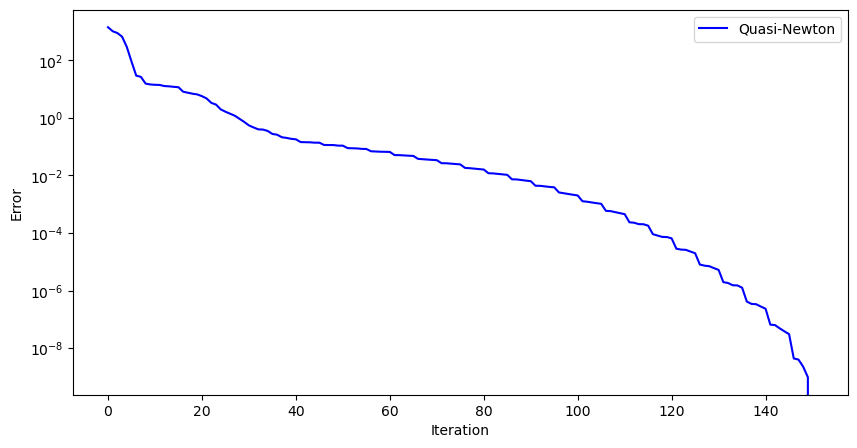

In [42]:
# Plot the error using the function plot_error_iter
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plot_error_iter(x_list_quasi, obj_list_quasi, f_exact, label='Quasi-Newton', color='blue')
# plot_error_iter(x_list_newton, obj_list_newton, fx, label='Newton', color='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.show()